In [1]:
import sys
sys.executable = '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/site-packages'
python_path = ['/home/chao/cantera/build/python', '/home/chao/RMG-Py', '/home/chao', '/home/chao/anaconda3/envs/chemcheck_env/lib/python38.zip', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/lib-dynload', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/site-packages']
sys.path.clear()
for path in python_path:
    sys.path.append(path)

In [2]:
import yaml
import cantera as ct
import numpy as np
from __future__ import division
from __future__ import print_function
import pandas as pd
import time
from textwrap import wrap
import math

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

# %matplotlib notebook
import matplotlib.pyplot as plt

Runnning Cantera version: 2.6.0a2


In [3]:
gas = ct.Solution('n_heptane/n_heptane_bm.yaml')

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474



In [4]:
def find_species_phase_index(species_name):
    """
    Return the phase object (gas or surface) and the index
    of the named species.
    """
    try:
        i = gas.species_index(species_name)
        return gas, i
    except ValueError:
        i = surf.species_index(species_name)
        return surf, i

def change_species_enthalpy(species_name, dH, T):
    """
    Find the species by name and change it's enthlapy by dH (in J/kmol)
    """
    phase, index = find_species_phase_index(species_name)

    species = phase.species(index)
    print(f"Initial H(298) = {species.thermo.h(T)/1e6:.1f} kJ/mol")
    dx = dH / ct.gas_constant  # 'dx' is in fact (delta H / R). Note that R in cantera is 8314.462 J/kmol
    assert isinstance(species.thermo, ct.NasaPoly2)
    # print(species.thermo.coeffs)
    perturbed_coeffs = species.thermo.coeffs.copy()
    perturbed_coeffs[6] += dx
    perturbed_coeffs[13] += dx
    
    species.thermo = ct.NasaPoly2(species.thermo.min_temp, species.thermo.max_temp, 
                            species.thermo.reference_pressure, perturbed_coeffs)
    #print(species.thermo.coeffs)
    phase.modify_species(index, species)
    print(f"Modified H(298) = {species.thermo.h(T)/1e6:.1f} kJ/mol")

# change_species_enthalpy('NH4NO3', 1e6) # 1 kJ/mol = 1e6 J/kmol
# change_species_enthalpy('NH4NO3', -1e6) # put it back for now

since we already know that the sensitive species are CH3(19), C2H6O2(62), C7H15(683), C2H4(11), CH4(10), C7H15(686), HO2(17), H2O2(18), O2(2), C7H16(1), we will tweak the enthalpy of these species and run the simulation

In [5]:
# read data from the original model
df = pd.read_csv('time_history.csv')
sens_sp = ['CH3(19)', 'C2H6O2(62)', 'C7H15(683)', 'C2H4(11)', 'CH4(10)', 'C7H15(686)', 'HO2(17)', 'H2O2(18)', 'O2(2)', 'C7H16(1)']
unnamed_name = df.iloc[:,0].name
df = df.rename(columns={unnamed_name: 'time'})
df.head(5)

,time,mass,volume,temperature,N2,Ar,Ne,C7H16(1),O2(2),CH(3),...,S(7275) sensitivity to the mole fraction of S(2003),S(7275) sensitivity to the mole fraction of S(2088),S(7275) sensitivity to the mole fraction of S(2090),S(7275) sensitivity to the mole fraction of S(2205),S(7275) sensitivity to the mole fraction of S(2359),S(7275) sensitivity to the mole fraction of S(2376),S(7275) sensitivity to the mole fraction of S(2385),S(7275) sensitivity to the mole fraction of S(2794),S(7275) sensitivity to the mole fraction of S(7214),S(7275) sensitivity to the mole fraction of S(7275)
0,1.226988e-08,2.943131,1.0,1000.000000,0.719288,0.0,0.0,0.062207,0.218506,4.583824e-29,...,4.008026e-22,-7.599165e-26,-2.025119e-26,-6.005111e-28,1.276393e-15,-5.788258e-17,5.541405e-28,4.087270e-11,-1.095461e-07,-4.087270e-11
1,3.630824e-08,2.943131,1.0,1000.000000,0.719288,0.0,0.0,0.062207,0.218506,3.560750e-28,...,-6.066222e-24,-3.742517e-28,1.296004e-25,-9.209676e-33,3.195105e-14,-7.801759e-16,-1.247514e-30,8.495461e-11,-1.113398e-07,-8.495461e-11
2,8.552156e-08,2.943131,1.0,999.999999,0.719288,0.0,0.0,0.062207,0.218506,1.392798e-27,...,2.285697e-22,-2.920993e-26,1.874785e-25,8.150122e-26,7.796276e-13,-6.869136e-15,7.585911e-28,1.833802e-10,-1.115777e-07,-1.833802e-10
3,1.679050e-07,2.943131,1.0,999.999998,0.719288,0.0,0.0,0.062207,0.218506,3.717576e-27,...,1.432550e-21,-2.451613e-23,2.048380e-23,5.316752e-25,7.099088e-12,1.982988e-14,-1.692588e-27,3.304974e-10,-1.110711e-07,-3.304974e-10
4,3.519077e-07,2.943131,1.0,999.999997,0.719288,0.0,0.0,0.062207,0.218506,1.116083e-26,...,-4.375465e-20,9.408260e-21,-4.171196e-21,-1.128504e-24,3.711638e-11,7.720798e-13,1.170437e-26,6.661539e-10,-1.098078e-07,-6.661539e-10


In [6]:
# given ignition delay time as 1.082e-02, filter out the data of species of interest at that time
for i,v in enumerate(list(df.iloc[:,0])):
#     if v == tau:
    if '{:.3e}'.format(v) == '1.082e-02':
        df_id = df.iloc[i,:]
df_id
# for sp in sens_sp:
#     sens_sp_mol_frac[sp] = df_id[sp]
# sens_sp_mol_frac
original_oh = df_id['OH(15)']
print(df_id['OH(15)'])

0.009497594855656393


In [7]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

Initial H(298) = 181.3 kJ/mol
Modified H(298) = 183.1 kJ/mol
Computed Ignition Delay: 1.116e-02 seconds. Took 2.15s to compute
Initial H(298) = -69.7 kJ/mol
Modified H(298) = -70.4 kJ/mol
Computed Ignition Delay: 1.102e-02 seconds. Took 2.15s to compute
Initial H(298) = 198.0 kJ/mol
Modified H(298) = 199.9 kJ/mol
Computed Ignition Delay: 1.139e-02 seconds. Took 2.13s to compute
Initial H(298) = 103.1 kJ/mol
Modified H(298) = 104.2 kJ/mol
Computed Ignition Delay: 1.114e-02 seconds. Took 2.12s to compute
Initial H(298) = -36.5 kJ/mol
Modified H(298) = -36.8 kJ/mol
Computed Ignition Delay: 1.122e-02 seconds. Took 2.11s to compute
Initial H(298) = 199.0 kJ/mol
Modified H(298) = 201.0 kJ/mol
Computed Ignition Delay: 1.188e-02 seconds. Took 2.24s to compute
Initial H(298) = 42.1 kJ/mol
Modified H(298) = 42.6 kJ/mol
Computed Ignition Delay: 1.166e-02 seconds. Took 2.29s to compute
Initial H(298) = -97.3 kJ/mol
Modified H(298) = -98.2 kJ/mol
Computed Ignition Delay: 1.115e-02 seconds. Took 2.2

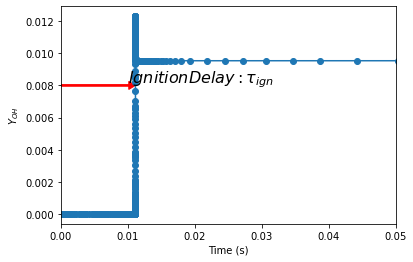

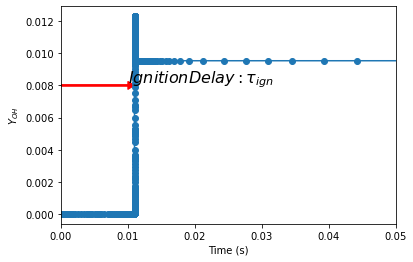

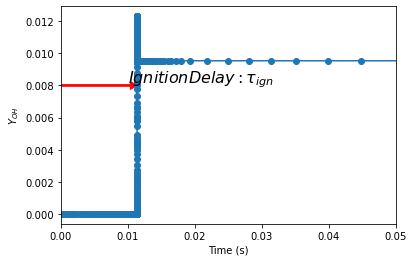

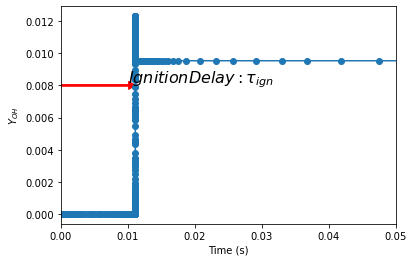

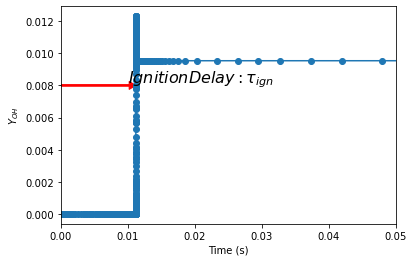

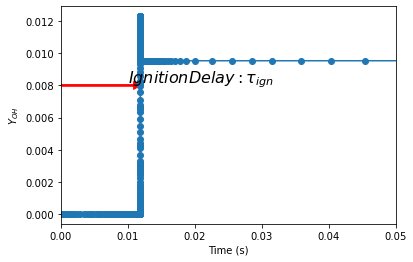

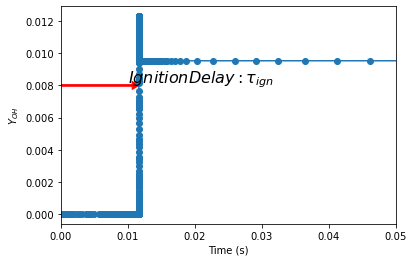

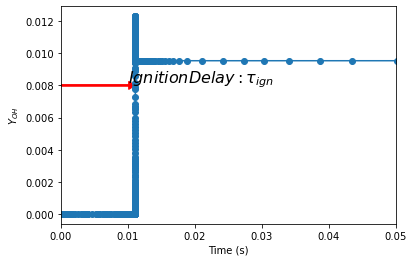

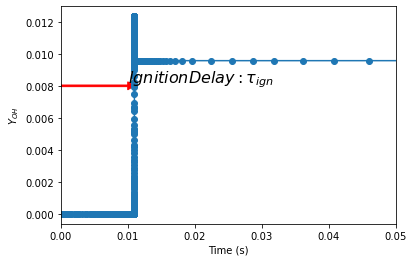

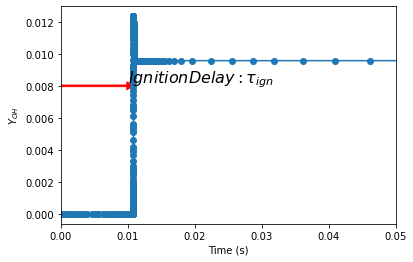

In [8]:
# tweak the enthalpy of sensitive species
id_time_bm = []
reactorTemperature = 1000 #Kelvin
for sp_name in sens_sp: 
    index = gas.species_index(sp_name)
    original_H = gas.species(index).thermo.h(reactorTemperature)
    d_H = original_H * 0.01
    change_species_enthalpy(sp_name, d_H, reactorTemperature)
    # print(f"{gas.species(index).name} : {gas.species(index).thermo.h(T)} J/kmol at {T} K")
    
    # running ignition delay
    reactorPressure = 8*101325.0 #Pascals

    gas.TP = reactorTemperature, reactorPressure

    # Define the fuel, oxidizer and set the stoichiometry
    gas.set_equivalence_ratio(phi=1.0, fuel='C7H16(1)', oxidizer={'O2(2)':1.0, 'N2':3.76})

    # Create a batch reactor object and add it to a reactor network
    # In this example, the batch reactor will be the only reactor
    # in the network
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    # now compile a list of all variables for which we will store data
    stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]

    # use the above list to create a DataFrame
    timeHistory = pd.DataFrame(columns=stateVariableNames)
    
    #Tic
    t0 = time.time()

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimatedIgnitionDelayTime = 1
    t = 0

    counter = 1;
    while(t < estimatedIgnitionDelayTime):
        t = reactorNetwork.step()
        if (counter%10 == 0):
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            gas_state = reactorNetwork.get_state()
    #         timeHistory.loc[t] = reactorNetwork.get_state()
            data = list(gas_state)
    #         print(data)
            timeHistory.loc[t] = data
        counter+=1

    # We will use the 'oh' species to compute the ignition delay
    tau = ignitionDelay(timeHistory, 'OH(15)')
    id_time_bm.append(tau)

    #Toc
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

    # If you want to save all the data - molefractions, temperature, pressure, etc
    # uncomment the next line
    timeHistory.to_csv(f"n_heptane/brute_force_thermo/time_history{sp_name}.csv")
    plt.figure()
    plt.plot(timeHistory.index, timeHistory['OH(15)'],'-o')
    plt.xlabel('Time (s)')
    plt.ylabel('$Y_{OH}$')

    plt.xlim([0,0.05])
    plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005,
              head_length=0.001, length_includes_head=True, color='r', shape='full')
    plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

In [32]:
#Calculate sens value
sens_sp = ['CH3(19)', 'C2H6O2(62)', 'C7H15(683)', 'C2H4(11)', 'CH4(10)', 'C7H15(686)', 'HO2(17)', 'H2O2(18)', 'O2(2)', 'C7H16(1)']
sens_value = []
for key, value in enumerate(sens_sp):
    df = pd.read_csv(f"n_heptane/brute_force_thermo/time_history{value}.csv")
    for i, v in enumerate(list(df.iloc[:,0])):
        if math.isclose(v, id_time_bm[key]) == True:
            sens_value.append((df.iloc[i+10,:]['OH(15)'] - original_oh) / original_oh / 0.01)
print(sens_value)

NameError: name 'sens_sp' is not defined

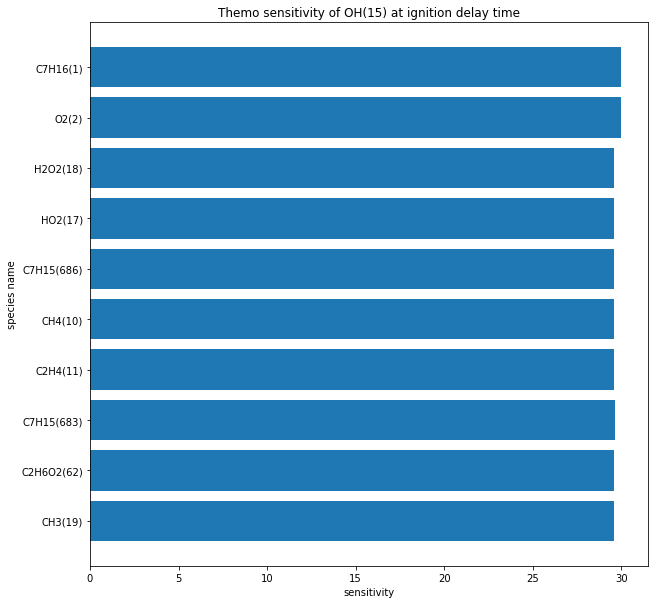

In [10]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.barh(sens_sp,sens_value)
plt.title('Themo sensitivity of OH(15) at ignition delay time')
plt.ylabel('species name')
plt.xlabel('sensitivity')
plt.show()

## Plot the thermo sensitivity analysis for model without Blowers-Masel

In [4]:
gas = ct.Solution('n_heptane/n_heptane_annotated.yaml')

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474



In [5]:
def find_species_phase_index(species_name):
    """
    Return the phase object (gas or surface) and the index
    of the named species.
    """
    try:
        i = gas.species_index(species_name)
        return gas, i
    except ValueError:
        i = surf.species_index(species_name)
        return surf, i

def change_species_enthalpy(species_name, dH, T):
    """
    Find the species by name and change it's enthlapy by dH (in J/kmol)
    """
    phase, index = find_species_phase_index(species_name)

    species = phase.species(index)
    print(f"Initial H(298) = {species.thermo.h(T)/1e6:.1f} kJ/mol")
    dx = dH / ct.gas_constant  # 'dx' is in fact (delta H / R). Note that R in cantera is 8314.462 J/kmol
    assert isinstance(species.thermo, ct.NasaPoly2)
    # print(species.thermo.coeffs)
    perturbed_coeffs = species.thermo.coeffs.copy()
    perturbed_coeffs[6] += dx
    perturbed_coeffs[13] += dx
    
    species.thermo = ct.NasaPoly2(species.thermo.min_temp, species.thermo.max_temp, 
                            species.thermo.reference_pressure, perturbed_coeffs)
    #print(species.thermo.coeffs)
    phase.modify_species(index, species)
    print(f"Modified H(298) = {species.thermo.h(T)/1e6:.1f} kJ/mol")

# change_species_enthalpy('NH4NO3', 1e6) # 1 kJ/mol = 1e6 J/kmol
# change_species_enthalpy('NH4NO3', -1e6) # put it back for now

In [6]:
df = pd.read_csv('time_history_normal_nh.csv')
sens_sp = ['CH3(19)', 'C2H6O2(62)', 'C7H15(683)', 'C2H4(11)', 'CH4(10)', 'C7H15(686)', 'HO2(17)', 'H2O2(18)', 'O2(2)', 'C7H16(1)']
unnamed_name = df.iloc[:,0].name
df = df.rename(columns={unnamed_name: 'time'})
df.head(5)

,time,time,mass,volume,temperature,N2,Ar,Ne,C7H16(1),O2(2),...,S(7275) sensitivity to the mole fraction of S(2003),S(7275) sensitivity to the mole fraction of S(2088),S(7275) sensitivity to the mole fraction of S(2090),S(7275) sensitivity to the mole fraction of S(2205),S(7275) sensitivity to the mole fraction of S(2359),S(7275) sensitivity to the mole fraction of S(2376),S(7275) sensitivity to the mole fraction of S(2385),S(7275) sensitivity to the mole fraction of S(2794),S(7275) sensitivity to the mole fraction of S(7214),S(7275) sensitivity to the mole fraction of S(7275)
0,3.748754e-08,3.748754e-08,2.943131,1.0,1000.000000,0.719288,0.0,0.0,0.062207,0.218506,...,9.176790e-24,2.563273e-26,2.338623e-27,2.532233e-30,3.302211e-14,-7.241133e-16,-9.644729e-31,8.723303e-11,-1.113804e-07,-8.723303e-11
1,9.481748e-08,9.481748e-08,2.943131,1.0,999.999999,0.719288,0.0,0.0,0.062207,0.218506,...,-5.357697e-22,3.822800e-24,1.965476e-25,4.941095e-26,1.140825e-12,-6.425190e-15,5.836334e-28,2.035982e-10,-1.115129e-07,-2.035982e-10
2,1.823840e-07,1.823840e-07,2.943131,1.0,999.999998,0.719288,0.0,0.0,0.062207,0.218506,...,-4.979577e-22,2.214828e-23,-8.246376e-24,5.948992e-25,9.328574e-12,5.266840e-14,-9.387205e-28,3.584076e-10,-1.109654e-07,-3.584076e-10
3,3.845550e-07,3.845550e-07,2.943131,1.0,999.999997,0.719288,0.0,0.0,0.062207,0.218506,...,-1.394232e-20,1.004568e-19,9.311343e-21,-8.706881e-25,4.429678e-11,1.083693e-12,1.611967e-26,7.277540e-10,-1.095843e-07,-7.277540e-10
4,7.477262e-07,7.477262e-07,2.943131,1.0,999.999993,0.719288,0.0,0.0,0.062207,0.218506,...,-6.739441e-19,-9.881377e-18,2.672228e-18,-2.692916e-23,7.838623e-11,3.535652e-12,-1.011477e-24,1.407167e-09,-1.072101e-07,-1.407167e-09


In [7]:
# given ignition delay time as 1.054e-02 s, filter out the data of species of interest at that time
for i,v in enumerate(list(df.iloc[:,0])):
#     if v == tau:
    if '{:.3e}'.format(v) == '1.054e-02':
        df_id = df.iloc[i,:]
df_id
# for sp in sens_sp:
#     sens_sp_mol_frac[sp] = df_id[sp]
# sens_sp_mol_frac
original_oh = df_id['OH(15)']
print(df_id['OH(15)'])

0.012195123074259002


In [8]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

Initial H(298) = 181.3 kJ/mol
Modified H(298) = 183.1 kJ/mol
Computed Ignition Delay: 1.088e-02 seconds. Took 2.27s to compute
Initial H(298) = -69.7 kJ/mol
Modified H(298) = -70.4 kJ/mol
Computed Ignition Delay: 1.075e-02 seconds. Took 2.15s to compute
Initial H(298) = 198.0 kJ/mol
Modified H(298) = 199.9 kJ/mol
Computed Ignition Delay: 1.121e-02 seconds. Took 2.03s to compute
Initial H(298) = 103.1 kJ/mol
Modified H(298) = 104.2 kJ/mol
Computed Ignition Delay: 1.097e-02 seconds. Took 2.11s to compute
Initial H(298) = -36.5 kJ/mol
Modified H(298) = -36.8 kJ/mol
Computed Ignition Delay: 1.105e-02 seconds. Took 2.08s to compute
Initial H(298) = 199.0 kJ/mol
Modified H(298) = 201.0 kJ/mol
Computed Ignition Delay: 1.179e-02 seconds. Took 2.17s to compute
Initial H(298) = 42.1 kJ/mol
Modified H(298) = 42.6 kJ/mol
Computed Ignition Delay: 1.154e-02 seconds. Took 2.06s to compute
Initial H(298) = -97.3 kJ/mol
Modified H(298) = -98.2 kJ/mol
Computed Ignition Delay: 1.093e-02 seconds. Took 2.1

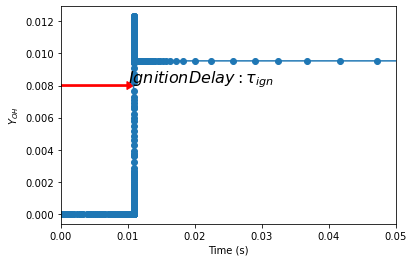

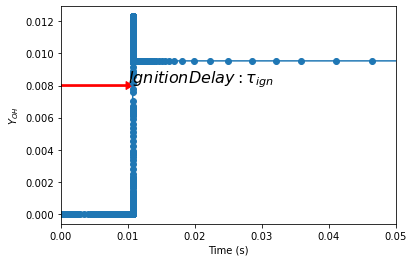

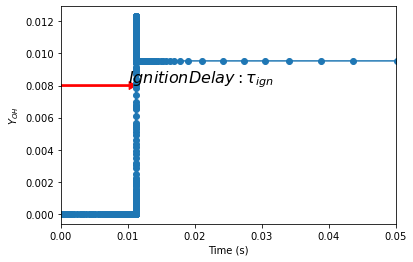

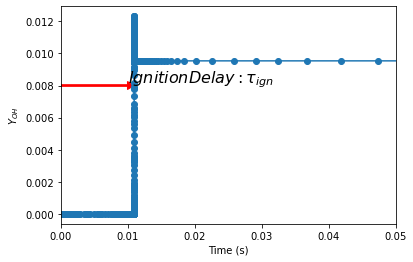

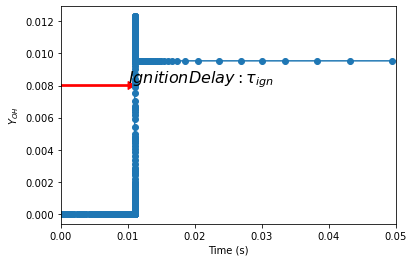

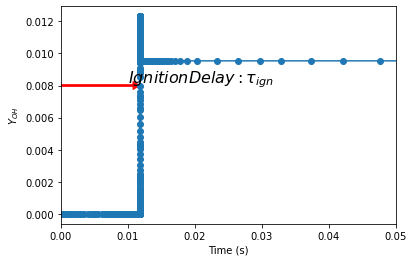

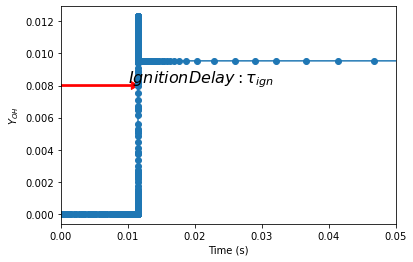

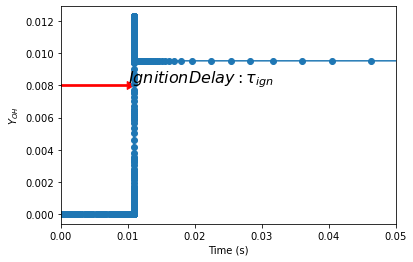

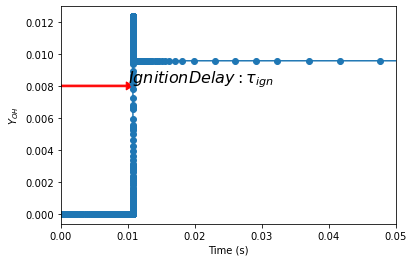

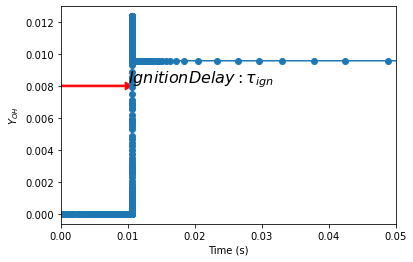

In [9]:
id_time_normal = []
# tweak the enthalpy of sensitive species
reactorTemperature = 1000 #Kelvin
for sp_name in sens_sp: 
    index = gas.species_index(sp_name)
    original_H = gas.species(index).thermo.h(reactorTemperature)
    d_H = original_H * 0.01
    change_species_enthalpy(sp_name, d_H, reactorTemperature)
    # print(f"{gas.species(index).name} : {gas.species(index).thermo.h(T)} J/kmol at {T} K")
    
    # running ignition delay
    reactorPressure = 8*101325.0 #Pascals

    gas.TP = reactorTemperature, reactorPressure

    # Define the fuel, oxidizer and set the stoichiometry
    gas.set_equivalence_ratio(phi=1.0, fuel='C7H16(1)', oxidizer={'O2(2)':1.0, 'N2':3.76})

    # Create a batch reactor object and add it to a reactor network
    # In this example, the batch reactor will be the only reactor
    # in the network
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    # now compile a list of all variables for which we will store data
    stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]

    # use the above list to create a DataFrame
    timeHistory = pd.DataFrame(columns=stateVariableNames)
    
    #Tic
    t0 = time.time()

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimatedIgnitionDelayTime = 1
    t = 0

    counter = 1;
    while(t < estimatedIgnitionDelayTime):
        t = reactorNetwork.step()
        if (counter%10 == 0):
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            gas_state = reactorNetwork.get_state()
    #         timeHistory.loc[t] = reactorNetwork.get_state()
            data = list(gas_state)
    #         print(data)
            timeHistory.loc[t] = data
        counter+=1

    # We will use the 'oh' species to compute the ignition delay
    tau = ignitionDelay(timeHistory, 'OH(15)')
    id_time_normal.append(tau)
    #Toc
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

    # If you want to save all the data - molefractions, temperature, pressure, etc
    # uncomment the next line
    timeHistory.to_csv(f"n_heptane/brute_force_thermo/time_history_normal{sp_name}.csv")
    plt.figure()
    plt.plot(timeHistory.index, timeHistory['OH(15)'],'-o')
    plt.xlabel('Time (s)')
    plt.ylabel('$Y_{OH}$')

    plt.xlim([0,0.05])
    plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005,
              head_length=0.001, length_includes_head=True, color='r', shape='full')
    plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

In [10]:
sens_value_normal = []
# id_time = ['1.088e-02', '1.075e-02', '1.121e-02', '1.097e-02', '1.105e-02', '1.179e-02', '1.154e-02', '1.093e-02', '1.078e-02', '1.063e-02']
for key, value in enumerate(sens_sp):
    df = pd.read_csv(f"n_heptane/brute_force_thermo/time_history_normal{value}.csv")
    for i,v in enumerate(list(df.iloc[:,0])):
        if math.isclose(v, id_time_normal[key]) == True:
            perturbed_oh = df.iloc[i+10,:]['OH(15)']
            sens_value_normal.append((perturbed_oh - original_oh) / original_oh / 0.01)
print(sens_value_normal)

[1.0059552431398846, 1.0065939625342393, 1.0204261165981754, 0.9959467152654695, 0.9853062848853691, 0.9917762059680146, 0.9976994536272219, 0.9765750820237623, 1.3049693738778472, 1.3132797588131235]


In [11]:
# copied from previous block
sens_value_bm = [29.57848779824035, 29.581017623507766, 29.614019794032984, 29.58398332660349, 29.57426244346865, 29.584370504337137, 29.597968186568686, 29.57378815157996, 29.985079037514172, 29.993290767135218]

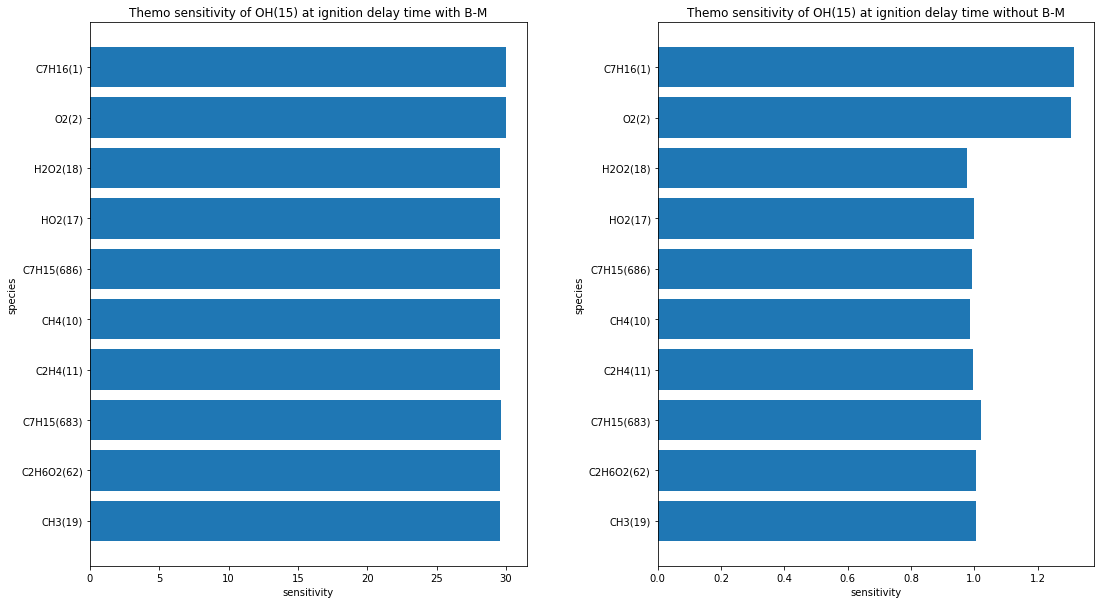

In [12]:
figure, axes = plt.subplots(ncols=2, figsize=(18,10))

# rxns2 = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
# rxns = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
axes[0].barh(sens_sp,sens_value_bm)
axes[1].barh(sens_sp, sens_value_normal)
# axes[0,0].title('Themo sensitivity of OH(15) at ignition delay time for n_heptane without B-M')
axes[0].set_title('Themo sensitivity of OH(15) at ignition delay time with B-M')
axes[1].set_title('Themo sensitivity of OH(15) at ignition delay time without B-M')

axes[0].set(ylabel='species', xlabel='sensitivity')
axes[1].set(ylabel='species', xlabel='sensitivity')
plt.subplots_adjust(wspace=0.3)

## Plot the sensitivity at ignition delay time after having the csv files

In [21]:
#Calculate sens value for bm
sens_sp = ['CH3(19)', 'C2H6O2(62)', 'C7H15(683)', 'C2H4(11)', 'CH4(10)', 'C7H15(686)', 'HO2(17)', 'H2O2(18)', 'O2(2)', 'C7H16(1)']
df_bm = pd.read_csv('time_history.csv')
original_oh = df_bm.loc[:,'OH(15)'][df_bm.loc[:,'OH(15)'].idxmax()]
sens_value_bm = []
for key, value in enumerate(sens_sp):
    df = pd.read_csv(f"n_heptane/brute_force_thermo/time_history{value}.csv")
    perturbed_oh = df.loc[:,'OH(15)'][df['OH(15)'].idxmax()]
    sens_value_bm.append((original_oh - perturbed_oh) / original_oh / 0.01)
print(sens_value_bm)

[0.07415656747686405, 0.0722056655341213, 0.04675568706260433, 0.0699186317197399, 0.0774149952185196, 0.06962005544947857, 0.059134056663706504, 0.07778075050565358, -0.2393906362840903, -0.24572319983199]


In [22]:
#Calculate sens value for normal model
sens_sp = ['CH3(19)', 'C2H6O2(62)', 'C7H15(683)', 'C2H4(11)', 'CH4(10)', 'C7H15(686)', 'HO2(17)', 'H2O2(18)', 'O2(2)', 'C7H16(1)']
df_normal = pd.read_csv('time_history_normal_nh.csv')
original_oh = df_normal.loc[:,'OH(15)'][df_normal.loc[:,'OH(15)'].idxmax()]
sens_value_normal = []
for key, value in enumerate(sens_sp):
    df = pd.read_csv(f"n_heptane/brute_force_thermo/time_history_normal{value}.csv")
    perturbed_oh = df.loc[:,'OH(15)'][df['OH(15)'].idxmax()]
    sens_value_normal.append((original_oh - perturbed_oh) / original_oh / 0.01)
print(sens_value_normal)

[0.06357551070852017, 0.06294355457910074, 0.04925786627678976, 0.07347806039247455, 0.08400582149977512, 0.0776044090467069, 0.07174388140751173, 0.09264457149604242, -0.2322724224731727, -0.24049481049536417]


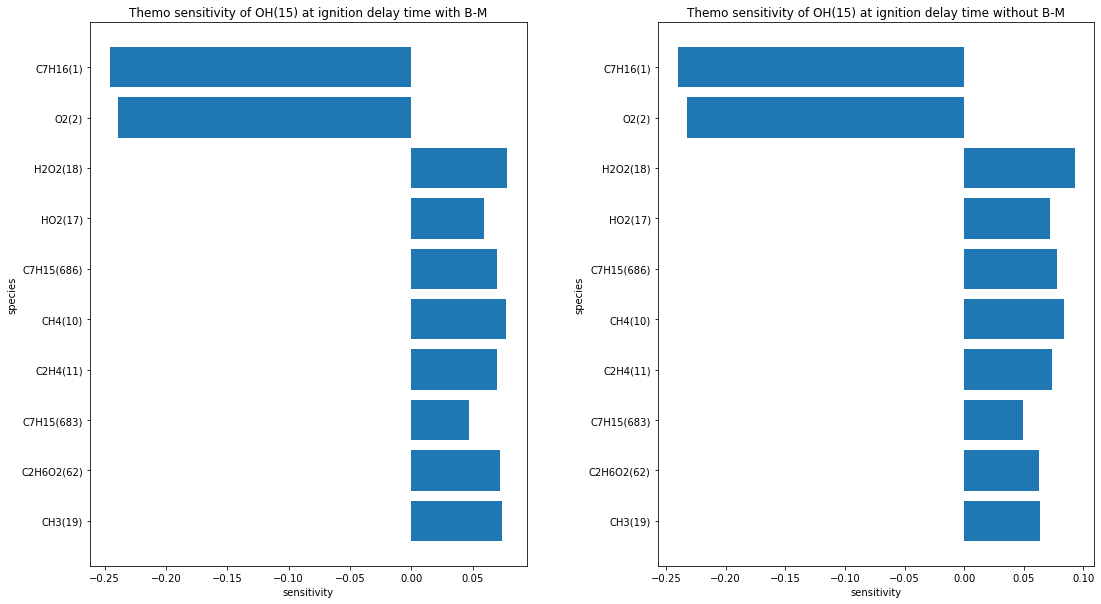

In [23]:
figure, axes = plt.subplots(ncols=2, figsize=(18,10))

# rxns2 = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
# rxns = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
axes[0].barh(sens_sp,sens_value_bm)
axes[1].barh(sens_sp, sens_value_normal)
# axes[0,0].title('Themo sensitivity of OH(15) at ignition delay time for n_heptane without B-M')
axes[0].set_title('Themo sensitivity of OH(15) at ignition delay time with B-M')
axes[1].set_title('Themo sensitivity of OH(15) at ignition delay time without B-M')

axes[0].set(ylabel='species', xlabel='sensitivity')
axes[1].set(ylabel='species', xlabel='sensitivity')
plt.subplots_adjust(wspace=0.3)

## Plot the sensitivity at other time points

### time before ignition delay 

In [3]:

def sensitivity_values(time_point, sens_sp, original_oh):
    sens_value = []
    for key, value in enumerate(sens_sp):
        df = pd.read_csv(f"n_heptane/brute_force_thermo/time_history{value}.csv")
#         for i,v in enumerate(list(df.iloc[:,0])):
#             if math.isclose(v, time_point, abs_tol=1e-6) == True:
#                 perturbed_oh = df.iloc[i,:]['OH(15)']
        time_points = np.array(df.iloc[:,0])
        idx = np.abs(time_point - time_points).argmin()
        perturbed_oh = df.iloc[idx,:]['OH(15)']
        sens_value.append((perturbed_oh - original_oh) / original_oh / 0.01)
    return sens_value

def sensitivity_values_normal(time_point, sens_sp, original_oh):
    sens_value = []
    for key, value in enumerate(sens_sp):
        df = pd.read_csv(f"n_heptane/brute_force_thermo/time_history_normal{value}.csv")
#         for i,v in enumerate(list(df.iloc[:,0])):
#             if math.isclose(v, time_point, abs_tol=1e-6) == True:
#                 perturbed_oh = df.iloc[i,:]['OH(15)']
        time_points = np.array(df.iloc[:,0])
        idx = np.abs(time_point - time_points).argmin()
        perturbed_oh = df.iloc[idx,:]['OH(15)']
        sens_value.append((perturbed_oh - original_oh) / original_oh / 0.01)
    return sens_value

In [28]:
# randomly select a time before ignition delay to plot the sensitivity
df_10 = pd.read_csv('time_history.csv').iloc[35,:]
time_bm = df_10[0]
original_oh_bm = df_10["OH(15)"]
print(time_bm, original_oh_bm)

0.0020615167111651487 9.41724965317208e-09


In [29]:
df_normal_original = pd.read_csv('time_history_normal_nh.csv')
# for i,v in enumerate(list(df_normal_original.iloc[:,0])):
#     if math.isclose(v, time_bm, abs_tol=1e-6):
time_data = np.array(df_normal_original.iloc[:,0])
min_idx = np.abs(time_data - time_bm).argmin()
time_normal = df_normal_original.iloc[min_idx,:][0]
original_oh_normal = df_normal_original.iloc[min_idx,:]['OH(15)']
print(time_normal, original_oh_normal)

0.0020325540607944274 1.1011385815403336e-08


In [30]:
sensitive_sp = ['CH3(19)', 'C2H6O2(62)', 'C7H15(683)', 'C2H4(11)', 'CH4(10)', 'C7H15(686)', 
               'HO2(17)', 'H2O2(18)', 'O2(2)', 'C7H16(1)']
sens_bm_value = sensitivity_values(time_bm, sensitive_sp, original_oh_bm)
sens_normal_value = sensitivity_values_normal(time_normal, sensitive_sp, original_oh_normal)

print(sens_bm_value,sens_normal_value)
print(len(sens_bm_value), len(sens_normal_value))

[-16.411033369042578, 12.519495251303164, -6.669265510199204, -10.232572445951444, -6.659358075509143, -34.537183485967255, -6.611157541058104, -4.523726634528005, -15.549474737395604, -15.66681511679206] [-7.183938942470096, 0.3713990171129176, -22.673437092039848, -9.133838308792019, -12.126392544840474, -37.46518629579362, -29.338721703345026, -9.789326500164647, -3.6898471077255994, -0.364856657290855]
10 10


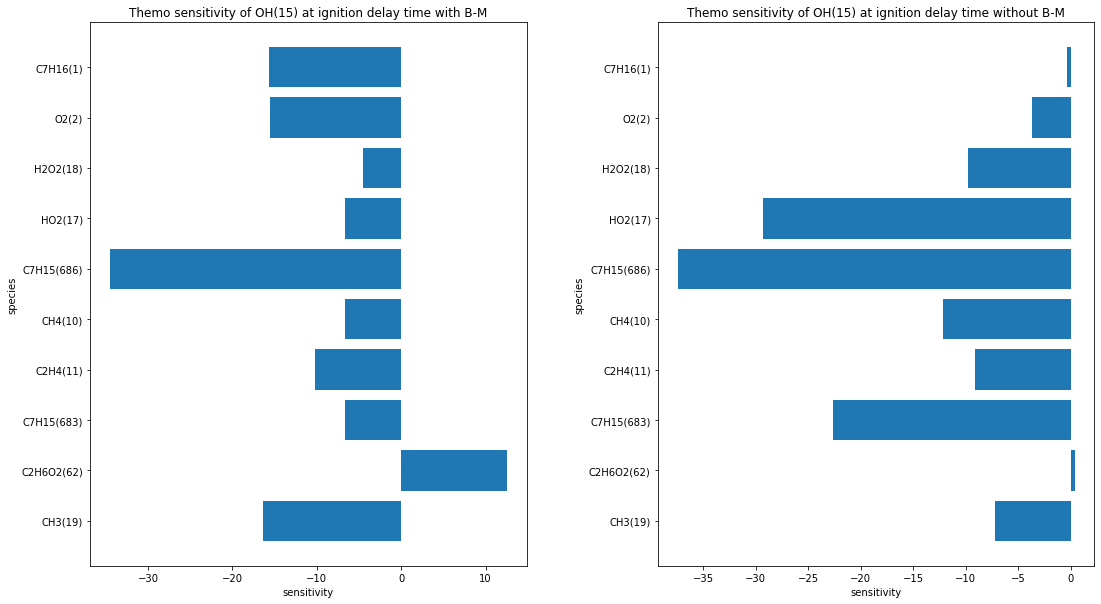

In [31]:
figure, axes = plt.subplots(ncols=2, figsize=(18,10))

# rxns2 = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
# rxns = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
axes[0].barh(sensitive_sp,sens_bm_value)
axes[1].barh(sensitive_sp, sens_normal_value)
# axes[0,0].title('Themo sensitivity of OH(15) at ignition delay time for n_heptane without B-M')
axes[0].set_title(f'Themo sensitivity of OH(15) at ignition delay time with B-M')
axes[1].set_title(f'Themo sensitivity of OH(15) at ignition delay time without B-M')

axes[0].set(ylabel='species', xlabel='sensitivity')
axes[1].set(ylabel='species', xlabel='sensitivity')
plt.subplots_adjust(wspace=0.3)

### time after ignition delay

In [4]:
# select a time point after ignition delay time
df_10 = pd.read_csv('time_history.csv').iloc[-30,:]
time_bm = df_10[0]
original_oh_bm = df_10["OH(15)"]
print(time_bm, original_oh_bm)

0.015091931563539312 0.009536605686175868


In [5]:
df_normal_original = pd.read_csv('time_history_normal_nh.csv')
# for i,v in enumerate(list(df_normal_original.iloc[:,0])):
#     if math.isclose(v, time_bm, rtol=1e-3):

time_data = np.array(df_normal_original.iloc[:,0])
min_idx = np.abs(time_data - time_bm).argmin()
time_normal = df_normal_original.iloc[min_idx,:][0]
original_oh_normal = df_normal_original.iloc[min_idx,:]['OH(15)']
print(time_normal, original_oh_normal)

0.014972813780641303 0.009536665468698715


In [6]:
sensitive_sp = ['CH3(19)', 'C2H6O2(62)', 'C7H15(683)', 'C2H4(11)', 'CH4(10)', 'C7H15(686)', 
               'HO2(17)', 'H2O2(18)', 'O2(2)', 'C7H16(1)']
sens_bm_value = sensitivity_values(time_bm, sensitive_sp, original_oh_bm)
sens_normal_value = sensitivity_values_normal(time_normal, sensitive_sp, original_oh_normal)

print(sens_bm_value,sens_normal_value)
print(len(sens_bm_value), len(sens_normal_value))

[-0.0007813240746702584, -0.0006441136763895259, -0.0002821545214495558, -0.00022244690543667245, -0.0002672088037542587, -0.0005715269227321086, 0.00010177069934608724, 0.0002087622130478638, 0.3590052867856899, 0.36877234569105977] [-0.0006887274622297597, -0.0005611236156780193, -0.00039693466992323645, -0.0003450786565001188, -0.00035359898223889954, -0.0006383184443103821, 2.97654938816229e-06, 0.0001475823411904063, 0.3589282311654815, 0.3687692361885009]
10 10


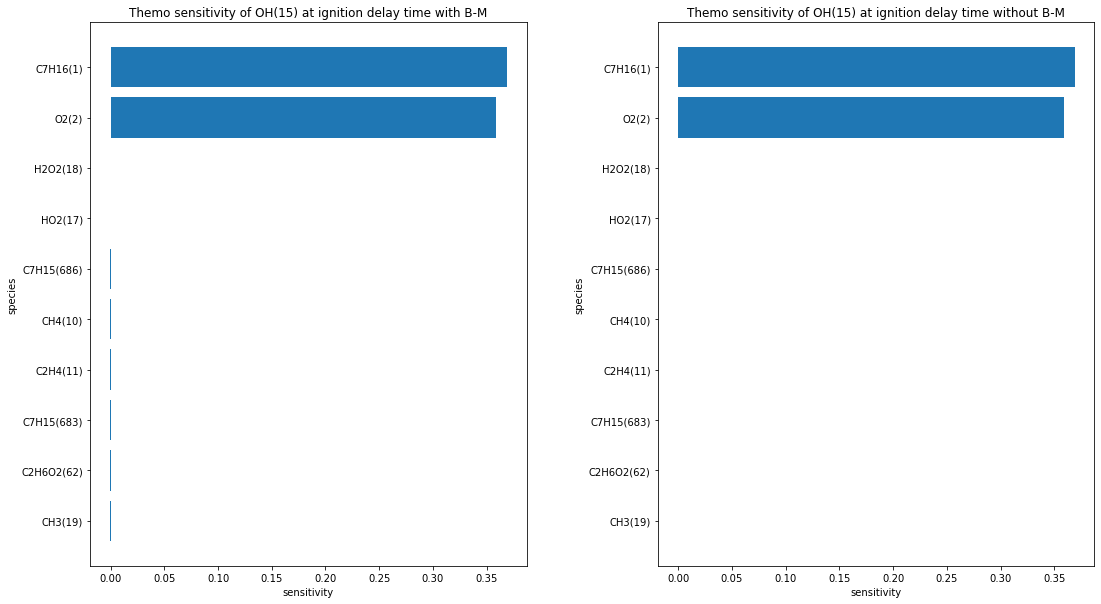

In [7]:
figure, axes = plt.subplots(ncols=2, figsize=(18,10))

# rxns2 = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
# rxns = [ '\n'.join(wrap(r, 20)) for s in sens_sp ]
axes[0].barh(sensitive_sp,sens_bm_value)
axes[1].barh(sensitive_sp, sens_normal_value)
# axes[0,0].title('Themo sensitivity of OH(15) at ignition delay time for n_heptane without B-M')
axes[0].set_title(f'Themo sensitivity of OH(15) at ignition delay time with B-M')
axes[1].set_title(f'Themo sensitivity of OH(15) at ignition delay time without B-M')

axes[0].set(ylabel='species', xlabel='sensitivity')
axes[1].set(ylabel='species', xlabel='sensitivity')
plt.subplots_adjust(wspace=0.3)